In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = '../data'
y_train = pd.read_csv(f'{path}/y_train.csv', index_col = 'key_value')

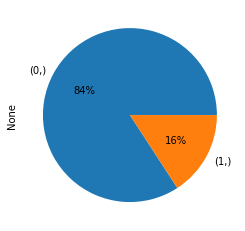

In [3]:
y_train.value_counts().plot(kind='pie', autopct='%1.0f%%');

## Entrenando LGBM con hiperparámetros

In [5]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 680), (396666, 680))

In [6]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.86488	training's binary_logloss: 0.285336	valid_1's auc: 0.850616	valid_1's binary_logloss: 0.296876
[200]	training's auc: 0.879241	training's binary_logloss: 0.273759	valid_1's auc: 0.853946	valid_1's binary_logloss: 0.294102
[300]	training's auc: 0.889931	training's binary_logloss: 0.264967	valid_1's auc: 0.854985	valid_1's binary_logloss: 0.293313
Early stopping, best iteration is:
[293]	training's auc: 0.889199	training's binary_logloss: 0.265553	valid_1's auc: 0.855023	valid_1's binary_logloss: 0.293297
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865167	training's binary_logloss: 0.28516	valid_1's auc: 0.851203	valid_1's binary_logloss: 0.296356
[200]	training's auc: 0.879416	training's binary_logloss: 0.273579	valid_1's auc: 0.854522	valid_1's binary_logloss: 0.293548
Early stopping, best iteration is:
[237]	

In [7]:
fi.sort_values(ascending=False).head(50)

edad                                                 0.009084
PRODUCTO_1_saldoMean_ult1meses                       0.009043
PRODUCTO_1_saldoMax_ult1meses                        0.008632
ubigeo_mode                                          0.008070
PRODUCTO_1_saldoSum_ult1meses                        0.005998
sexo_0                                               0.005835
PRODUCTO_1_saldoMedian_ult1meses                     0.005634
PRODUCTO_0_saldoMin_ult12meses                       0.004803
estadocontribuyente_0                                0.004794
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.004652
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult12meses    0.004635
PRODUCTO_6_saldoSum_ult12meses                       0.004607
PRODUCTO_3_saldoUnique_ult12meses                    0.004555
PRODUCTO_0_saldoStd_ult12meses                       0.004490
PRODUCTO_8_saldoSum_ult12meses                       0.004423
PRODUCTO_3_saldoMedian_ult1meses                     0.004272
cod_inst

In [8]:
fi.to_pickle('fi_lightgbm.pkl')

In [9]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

## Catboost con parametros casi estandar
### CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6)

In [10]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 680), (396666, 680))

In [12]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index]

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index]

    learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6, random_state=42)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, 
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7354041	test1: 0.7409218	best: 0.7409218 (0)	total: 551ms	remaining: 9m 9s
100:	test: 0.8474995	test1: 0.8431231	best: 0.8431231 (100)	total: 42.3s	remaining: 6m 16s
200:	test: 0.8580141	test1: 0.8488303	best: 0.8488303 (200)	total: 1m 22s	remaining: 5m 26s
300:	test: 0.8651099	test1: 0.8507718	best: 0.8507819 (299)	total: 2m 3s	remaining: 4m 47s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.851562118
bestIteration = 360

Shrink model to first 361 iterations.
********** 1 **********
Learning rate set to 0.128212
0:	test: 0.7497525	test1: 0.7491437	best: 0.7491437 (0)	total: 455ms	remaining: 7m 34s
100:	test: 0.8473951	test1: 0.8438024	best: 0.8438024 (100)	total: 41.3s	remaining: 6m 7s
200:	test: 0.8576597	test1: 0.8488468	best: 0.8488468 (200)	total: 1m 17s	remaining: 5m 8s
300:	test: 0.8650543	test1: 0.8511419	best: 0.8511419 (300)	total: 1m 50s	remaining: 4m 16s
400:	test: 0.8708024	test1: 0.85232

In [13]:
fi.to_pickle('fi_catboost.pkl')

In [14]:
train_probs_catboost = train_probs
test_probs_catboost = test_probs
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

## Entrenamiento de modelo XgBoost

In [14]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [15]:
from xgboost  import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = XGBClassifier(n_estimators=1000, booster='gbtree', colsample_bytree=0.8, 
                            subsample = 0.8, max_depth=4,  learning_rate=0.3)
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.71867	validation_1-auc:0.72320
[100]	validation_0-auc:0.86630	validation_1-auc:0.84686
[159]	validation_0-auc:0.87726	validation_1-auc:0.84776
********** 1 **********
[0]	validation_0-auc:0.72019	validation_1-auc:0.71819
[100]	validation_0-auc:0.86656	validation_1-auc:0.84752
[112]	validation_0-auc:0.86884	validation_1-auc:0.84768
********** 2 **********
[0]	validation_0-auc:0.71867	validation_1-auc:0.72510
[100]	validation_0-auc:0.86763	validation_1-auc:0.85002
[175]	validation_0-auc:0.88030	validation_1-auc:0.85072
********** 3 **********
[0]	validation_0-auc:0.72175	validation_1-auc:0.72340
[100]	validation_0-auc:0.86695	validation_1-auc:0.84898
[130]	validation_0-auc:0.87246	validation_1-auc:0.84919
********** 4 **********
[0]	validation_0-auc:0.72201	validation_1-auc:0.70930
[100]	validation_0-auc:0.86989	validation_1-auc:0.84073
[143]	validation_0-auc:0.87738	validation_1-auc:0.84112
*********************
roc auc estimado:  0.8475722843014554
roc auc varian

In [16]:
fi.sort_values(ascending=False).head(50)

PRODUCTO_12_saldoMin_ult1meses                      0.075974
RIESGO_DIRECTO_2_saldoMean_ult1meses                0.052980
RIESGO_DIRECTO_2_saldoMin_ult2meses                 0.045184
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult1meses    0.042137
COD_CLASIFICACION_DEUDOR_5_saldoMin_ult1meses       0.022472
COD_CLASIFICACION_DEUDOR_1_saldoStd_ult2meses       0.020933
COD_CLASIFICACION_DEUDOR_3_saldoStd_ult4meses       0.020831
PRODUCTO_12_saldoMax_ult1meses                      0.017672
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult4meses    0.016055
COD_CLASIFICACION_DEUDOR_1_saldoMedian_ult4meses    0.015935
tipo_credito_11_saldoMean_ult1meses                 0.015827
COD_CLASIFICACION_DEUDOR_1_saldoUnique_ult2meses    0.015041
condicion_1_saldoMax_ult2meses                      0.013716
RIESGO_DIRECTO_2_saldoMedian_ult1meses              0.012992
RIESGO_DIRECTO_2_saldoMean_ult2meses                0.012878
PRODUCTO_0_saldoMedian_ult1meses                    0.011044
cod_instit_financiera_ma

In [17]:
fi.to_pickle('fi_xgb.pkl')

In [18]:
train_probs_lightgbm_cf = train_probs
test_probs_lightgbm_cf= test_probs
train_probs_lightgbm_cf.to_pickle('train_probs_xgb.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_xgb.pkl')

## Entrenando GradientBosstingClassifier

In [15]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 680), (396666, 680))

In [16]:
var_categ = [i for i in train.columns if 'mode' in i]
var_cuanti = [i for i in train.columns if 'mode' not in i]

In [17]:
for i in var_cuanti:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())    

for i in var_categ:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0]) 

In [19]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.fit
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                         max_depth=5, verbose=1, max_features=0.82, random_state=42,
                                         n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)
   
    learner.fit(Xt, yt)        
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
    print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    
        
test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7717           0.0966          245.29m
         2           0.7281           0.0420          244.48m
         3           0.6984           0.0260          252.08m
         4           0.6868           0.0136          263.77m
         5           0.6726           0.0129          266.19m
         6           0.6600           0.0102          266.89m
         7           0.6536           0.0045          261.95m
         8           0.6488           0.0068          258.47m
         9           0.6449           0.0043          256.60m
        10           0.6360           0.0054          256.92m
        20           0.6071           0.0015          331.62m
roc_auc_estimado de : 0.8347402903119385
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7708           0.1043          467.14m
         2           0.7251           0.0

In [20]:
fi.sort_values(ascending=False).head(50)

COD_CLASIFICACION_DEUDOR_5_saldoSum_ult6meses        0.135634
COD_CLASIFICACION_DEUDOR_5_saldoSum_ult2meses        0.101147
PRODUCTO_6_saldoMax_ult12meses                       0.064503
COD_CLASIFICACION_DEUDOR_1_saldoMean_ult2meses       0.041642
RIESGO_DIRECTO_2_saldoSum_ult2meses                  0.035671
cod_instit_financiera_max_ult1mes                    0.033629
PRODUCTO_12_saldoMax_ult1meses                       0.033293
RIESGO_DIRECTO_1_saldoSum_ult1meses                  0.026404
RIESGO_DIRECTO_2_saldoSum_ult4meses                  0.022858
condicion_9_saldoSum_ult1meses                       0.017490
tipo_credito_12_saldoSum_ult1meses                   0.016029
PRODUCTO_6_saldoMax_ult1meses                        0.015940
cod_instit_financiera_nunique_ult1mes                0.013738
PRODUCTO_6_saldoMean_ult1meses                       0.013300
tipo_credito_11_saldoMean_ult1meses                  0.013142
COD_CLASIFICACION_DEUDOR_0_saldoUnique_ult1meses     0.012376
COD_CLAS

In [21]:
fi.to_pickle('fi_gbc.pkl')

In [22]:
train_probs_gbc = train_probs
test_probs_gbc = test_probs
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

## Entrenando LGBM categorical features

In [4]:
train = pd.read_pickle('../data/train_features680_score_0.85558.pkl') 
test = pd.read_pickle('../data/test_features680_score_0.85558.pkl')
train.shape, test.shape

((358487, 1320), (396666, 1320))

In [7]:
var_categ = [c for c in train.columns if 'mode' in c]
for c in var_categ:
    train[c] = train[c].astype('category')
    test[c] = test[c].astype('category')

In [8]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import numpy as np
folds = [train.index[t] for t, v in KFold(5).split(train)]
test_probs = []
train_probs = []
fi = []
for i, idx in enumerate(folds):
    print("*"*10, i, "*"*10)
    Xt = train.loc[idx]
    yt = y_train.loc[Xt.index].target

    Xv = train.drop(Xt.index)
    yv = y_train.loc[Xv.index].target

    learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                   subsample=0.8, max_bin=200, learning_rate=0.1)
    
    learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
    test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
    train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
    fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))

test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
train_probs = pd.concat(train_probs)
fi = pd.concat(fi, axis=1).mean(axis=1)
print("*" * 21)
print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))  

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.87377	training's binary_logloss: 0.279481	valid_1's auc: 0.849385	valid_1's binary_logloss: 0.297542
[200]	training's auc: 0.891032	training's binary_logloss: 0.264902	valid_1's auc: 0.852293	valid_1's binary_logloss: 0.295352
Early stopping, best iteration is:
[220]	training's auc: 0.893876	training's binary_logloss: 0.262551	valid_1's auc: 0.852501	valid_1's binary_logloss: 0.295185
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.873679	training's binary_logloss: 0.279659	valid_1's auc: 0.848266	valid_1's binary_logloss: 0.298328
[200]	training's auc: 0.891073	training's binary_logloss: 0.265048	valid_1's auc: 0.850959	valid_1's binary_logloss: 0.296141
Early stopping, best iteration is:
[231]	training's auc: 0.895043	training's binary_logloss: 0.261529	valid_1's auc: 0.851234	valid_1's binary_logloss: 0.295913
********** 2 **********
Train

In [9]:
fi.sort_values(ascending=False).head(50)

ciiu_mode                                            0.112486
cod_instit_financiera_mode_ult1mes                   0.039028
ubigeo_mode                                          0.037757
cod_instit_financiera_mode_ult12mes                  0.024806
cod_instit_financiera_mode_ult2mes                   0.022791
cod_instit_financiera_mode_ult3mes                   0.016482
cod_instit_financiera_mode_ult11mes                  0.016149
cod_instit_financiera_mode_ult10mes                  0.014884
cod_instit_financiera_mode_ult4mes                   0.013109
cod_instit_financiera_mode_ult8mes                   0.012756
cod_instit_financiera_mode_ult5mes                   0.012124
cod_instit_financiera_mode_ult6mes                   0.011628
cod_instit_financiera_mode_ult7mes                   0.011587
PRODUCTO_1_saldoMean_ult1meses                       0.008456
PRODUCTO_1_saldoMax_ult1meses                        0.007019
edad                                                 0.006704
codzona_

In [11]:
fi.to_pickle('fi_lightgbm_v2.pkl')

In [12]:
train_probs_lightgbm = train_probs
test_probs_lightgbm = test_probs
train_probs_lightgbm.to_pickle('train_probs_lightgbm_v2.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm_v2.pkl')